# GEONE - GEOSCLASSIC

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

The following functions are used for a grid, i.e. the evaluation are done at the centers of the grid cells:

- `geone.geosclassicinterface.estimate`: for estimation (interpolation) (kriging estimates and standard deviation)
- `geone.geosclassicinterface.simulate`: for simulation (sequential Gaussian simulation, SGS)

*Note: these functions detect the space dimension (1, 2, or 3) based on the parameter `dimension` that gives the number of cells along each axis.*

These functions launch a C program running in parallel (based on *OpenMP*) for the simulation / estimation **in a grid**, assuming conditioning data located at the center of the grid cells. However, the given conditioning data can be located anywhere in the grid: preliminary steps (before launching the C program) are applied to "transfer" the data points to the cell centers (see below for more details).

The following functions can be used for evaluation at any points (which are used in the preliminary steps):
- `geone.covModel.krige`: estimation (kriging)
- `geone.covModel.sgs[_mp]`: simulation (SGS) (the version with suffix `_mp` allows for multiprocessing, simultaneous parallel processes)
- `geone.covModel.sgs_at_inequality_data_points[_mp]` for simulation at inequality data points

*Note: these functions detect the space dimension (1, 2, or 3) based on the parameter `xu` that gives the points where the estimation or simulation haas to be done.*

*Note: computing estimation or simulation in an entire grid is much more faster with the dedicated functions `geone.geosclassicinterface.estimate` and `geone.geosclassicinterface.simulate`; consider also multiprocessing computation (see below) for optimizing the computational time.*

## Interpolation type (kriging type)
Estimation and simulation are done for a continuous variable, based on simple kriging or ordinary kriging according to the parameter `method`: 
- `method='simple_kriging'`: simple kriging
- `method='oridinary_kriging'`: ordinary kriging (default)

Kriging systems are based on a covariance model: required parameter `cov_model`. See the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples. 

*Note: non-stationarities may be handled: local rotation, local multiplier for sill and/or range(s), see the notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb`.*

Simple kriging allows to specify the mean and the variance, stationary (global) or non-stationary (local). By default the mean is set to the mean of the hard data values (stationary) or zero if no hard data is present, and the variance is determined by the covariance model used and not modified.

Ordinary kriging accounts for the mean of the considered variable at the vinicity of the estimated / simulated point. Note that one can also specify a mean, which is used when no informed points is present in the search neighborhood of the estimated / simulated point.

## Conditioning data
### Hard data (or simply data) 
Hard data (or simply data) consists of an ensemble of points, where each data point is given by a location (in the grid), a value (for the variable to be estimated or simulated), and optionally an error: the error is assumed to follow a zero-mean Gaussian distribution of given standard deviation. Note that the errors are considered as uncorrelated. The parameters passed to the functions are:
- `x`: data locations
- `v`: data values
- `v_err_std`: the error standard deviation

### Inequality data
Inequality data consists of an ensemble of points, where each data point is given by a location (in the grid), a minimal (lower bound) value and a maximal (upper bound) value (for the variable to be estimated or simulated). Note that 
the value `np.nan` or `-np.inf` (resp. `np.inf`) can be specified as minimal (resp. maximal) value for point without lower (resp. upper) bound. No error can be specified on inequality data values. The parameters passed to the functions are:
- `x_ineq`: inequality data locations
- `v_ineq_min`: minimal data values (lower bound)
- `v_ineq_max`: maximal data values (upper bound)

### Inequality data transformation
To deal with inequality data, the computation relies on a transfomation of each inequality data point in an "equality data point" defined by a value and an error standard deviation. This allows to do kriging on the entire grid (function `geone.geosclassicinterface.estimate`). 

For simulation in a grid, two modes are proposed (parameter of the function `geone.geosclassicinterface.simulate`):
- `mode_transform_ineq_to_data=True`: inequality data is transfomed (results relying on the Gaussian approximation)
- `mode_transform_ineq_to_data=False`: inequality data is not transformed (results not relying on the Gaussian approximation)

See below for more details about the transformation and the two simulation modes.

## Search neighborhood 
The kriging system to solve for the evaluation / simulation in one grid cell (or point) takes into account informed cells within a search ellipsoid centered around the evaluated / simulated cell. The search ellipsoid can be specified with the keyword arguments `searchRadius` (default: `None`) and `searchRadiusRelative` (float, default: `1.2`):
- if `searchRadius` is specified (not `None`): this is the radius of the search ellipsoid in any direction (the parameter `searchRadiusRelative` is not used)
- if `searchRadius=None`, then the parameter `searchRadiusRelative` is used: the search ellipsoid is oriented as the covariance model (orientation of main axes), with radii (half-axes) `searchRadiusRelative` $cdot r_i$ where $r_i$ is the (maximal) range of the covariance model along the direction $i$, for $i =1\ldots d$ ($d$ being the space dimension).

The kriging system accounts for at most the `nneigborMax` (`int`, default: `12`) informed grid cells within the search ellipsoid. The cells the closest to the central cell are taken, with respect to the ascending sort specified by the keyword argument `searchNeighborhoodSortMode`:

- `searchNeighborhoodSortMode=0`: distance in the usual axes system
- `searchNeighborhoodSortMode=1` (default): distance in the axes sytem supporting the covariance model and accounting for anisotropy given by the ranges
- `searchNeighborhoodSortMode=2`: minus the evaluation of the covariance model

**Remark - unique search neighborhood** 

For estimation (function `geone.geosclassicinterface.estimate` and `geone.covModel.krige`), a unique neighborhood can be used, *i.e.* all data points are taken into account in the kriging system for every node, by setting the keyword argument 
- `use_unique_neighborhood=True` (default: `False`)

In this case, the parameters `searchRadius`, `searchRadiusRelative`, `nneighborMax` and `searchNeighborhoodSortMode` are ignored (unused).

## Computational resources - multiprocessing
The external C function (Geos-Classic library) is launched in parallel (based on *OpenMP*), using a given number of threads. Moreover, for simulation, multiple parallel processes can be considered (several parallel calls of the function). 

In the same way, for the simulation (SGS) at any data points (resp. inequality data points), multiple parallel processes may be used: the function `sgs_mp` (resp. `sgs_at_inequality_data_points_mp`) launches several processes (several calls of the function `sgs` (resp. `sgs_at_inequality_data_points`)).

The parameters to specify the computational resources for the estimation (interpolation), function `geone.geosclassicinterface.estimate`:
- `nthreads` : number of threads for the interpolation in the grid (C function, 1 process)
- `nproc_sgs_at_ineq`: number of parallel process(es) for the simulations at inequality data point (see below) (by default `nthreads`)

and the parameters for the simulation, function `geone.geosclassicinterface.simulate`:
- `nproc`: number of parallel process(es) for the simulations in the grid (C function)
- `nthreads_per_proc` : number of threads used per process (C function)
- `nproc_sgs_at_ineq`: number of parallel process(es) for the simulations at inequality data point (see below) (by default `nproc` $\cdot$ `nthreads_per_proc`)

Note that for the simulation, this represents, in terms of computational resources, a total of `nproc * nthreads_per_proc` CPUs (for the part with the C function); this number should not exceed the the total number of CPUs of the system (retrieved by `multiprocessing.cpu_count()` or `os.cpu_count()`).

### Computational resources - Important remark
Although some default values are proposed, it is strongly recommended to specify the above parameters controlling the computational resources; a few tests on the machine used allows to select a good set-up.
 
## Wrapper `geone.multiGaussian.multiGaussianRun`
The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper: with keyword arguments

- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate`
- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate`

## Ouput - getting the results
The functions `geone.geosclassicinterface.estimate` and `geone.geosclassicinterface.simulate` returns a dictionary
- `geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

with
- `geosclassic_output['image']`: a geone image (instance of the class `geone.img.Img`) with 
    - for `geone.geosclassicinterface.estimate`: two variables, the first variable (index 0) is the kriging estimate, and the second variable (index 1) is the kriging standard deviation
    - for `geone.geosclassicinterface.simulate`: `nreal` variables, where `nreal` is the number of realizations done, the i-th variable (index i) being the i-th realization
- `geosclassic_output['nwarning']`: an `int`, the total number of warning(s) encountered during the run
- `geosclassic_output['warnings']`: a list of strings (possibly empty), the list of all distinct warning messages

### Output using the wrapper `geone.multiGaussian.multiGaussianRun`
The function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'` (default): an "image" (class `geone.img.Img`) is returned

Moreover, setting the keyword argument `retrieve_warnings=True` (`False` by default), the function also returns the list of warnings encountered. More precisely, the function can be used as follows:

- `out = geone.multiGaussian.multiGaussianRun(..., retrieve_warning=False)`
- `out, warnings = geone.multiGaussian.multiGaussianRun(..., retrieve_warning=False)`

Then, `out` will contain

- the *image* `geosclassic_output['image']` if `output_mode` is set to `'img'`
- the array `geosclassic_output['image'].val` if `output_mode` is set to `'array'`

and `warnings` will contain the list `geosclassic_output['warnings']`.

## Details - Computing estimation and simulation in a grid

The main steps applied in the functions `geone.geosclassicinterface.estimate` (for estimation, kriging) and `geone.geosclassicinterface.simulate` (for simulation, SGS, with `mode_transform_ineq_to_data=True` (see below)) are

1. If there is inequality data, they are first transformed to new data with error: for that, an ensemble of simulations at inequality data points is generated, then at each location, the ensemble of values is transformed to a new data value with an error standard deviation (std).
2. A new dataset is formed by grouping the original (equality) data (with their error std) and the new data with their own error std from step 1.
3. The dataset from step 2 is then kriged at the center of grid cells containing at least one data point, this results in a dataset at cell centers (values and error std are respectively the kriging estimates and the kriging std)
4. The dataset at cell centers from step 3 is then kriged or simulated on the grid (at cell centers), using an external C function (Geos-Classic library)

### Remark about inequality data - alternative for simulation
The simulations at inequality data points are done using the function `geone.covModel.sgs_at_inequality_data_points[_mp]`, the number of simulations is given by the parameter `transform_ineq_to_data_with_err_nsim`. Each simulation is done based on a Gibbs sampler: several paths (`nGibbsSamplerPath`) visiting all the inequality data locations are considered where, at a given location, a value is simulated according to the Gaussian distribution resulting from the solution of the kriging system accounting for the neighboring points, truncated with respect to the inequality data value at that location.

The ensemble of simulated values at an inequality data point does not follows a Gaussian distribution, and in particular is often skewed. However, in the step 1. above, a Gaussian distribution (value with error std) is determined, using the function `geone.CovModel.values_to_mean_and_err_std`. This is an approximation, which allows to do kriging (on the entire grid).

The function `geone.CovModel.values_to_mean_and_err_std` returns the mean `mu` and the standard deviation `sigma` of a Gaussian distribution with `mu` the mean of the input values respecting the inequality(ies), i.e. within the input lower bound (`v_min`) and input upper bound (`v_max`), and `std` defined such that at least a proportion `p/2` (`p=0.95` by default, parameter of the function) of the Gaussian distribution is between `mu` and `v_min` resp. between `mu` and `v_max`.

For simulations in a grid, i.e. function `geone.geosclassicinterface.simulate`, an alternative not relying on this approximation is proposed and used if `mode_transform_ineq_to_data=False`; in that case, to generate `nreal` realizations, the main steps are:

1. If there is inequality data, `nreal` simulations at inequality data points is generated, each simulation being a new data (without error).
2. For each simulation of point 1: a new dataset is formed by grouping the original (equality) data (with their error std) and the new data of that simulation
3. Each dataset from step 2b is kriged at the center of grid cells containing at least one data point, this results in a dataset at cell centers (values and error std are respectively the kriging estimates and the kriging std)
4. Each dataset at cell centers from step 3b (`nreal` at total) is used to generate 1 SGS realization on the grid (at cell centers), using an external C function (Geos-Classic library)

### Pre-processing data (for estimation and simulation)
Before starting the interpolation or simulation (four steps above), the data points and inequality data points can be first pre-processed (optional, if `preprocess_data_and_ineq_in_grid=True`) in order to have at most one data point or inequality data point per grid cell, by proceeding as follows:

- if one grid cell contains both data point(s) and inequality data point(s), then the inequality data point(s) are removed
- if one grid cell contains several data points (no inequality data), they are aggregated in that cell into one data point by taking the mean position, the mean value, and the maximal error standard deviation of data points in that cell
- if one grid cell contains several inequality data points (no equality data) they are aggregated in that cell into one data point by taking the mean position, and if `preprocess_ineq_less_constrained=True`: the minimal lower bound (from `v_ineq_min`), and the maximal upper bound (from `v_ineq_max`), or if `preprocess_ineq_less_constrained=False`: the maximal lower bound (from `v_ineq_min`), and the minimal upper bound (from `v_ineq_max`) i.e. the less (resp. more) contraining bounds are kept if `preprocess_ineq_less_constrained=True` (resp. `preprocess_ineq_less_constrained=False`); note that the minimum or maximam is taken over non-infinite bounds (if any)

## Examples in 1D
In this notebook, examples in 1D with a stationary covariance model are given.

*Remark: for examples with non-stationary covariance models, see jupyter notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb`.*


## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Grid (1D)

In [3]:
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin

## Covariance model

In 1D, a covariance model is given by an instance of the class `geone.covModel.covModel1D`.

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

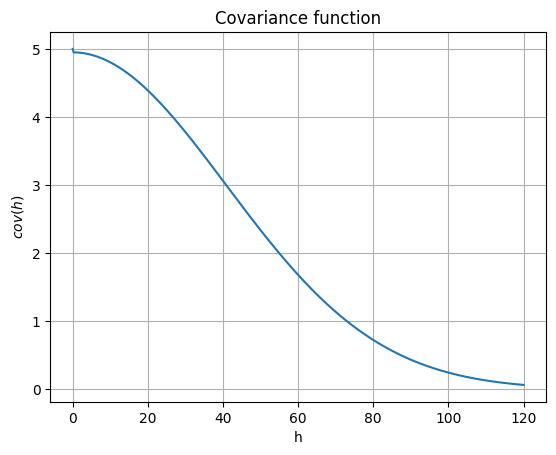

In [4]:
cov_model = gn.covModel.CovModel1D(elem=[
    ('gaussian', {'w':4.95, 'r':100}), # elementary contribution
    ('nugget', {'w':.05})             # elementary contribution
    ], name='model-1D example')

plt.figure()
cov_model.plot_model()
plt.title('Covariance function')
plt.show()

## 1. Example with data (no inequality data)

In [5]:
# Data
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                 #    float: same for all data points
                                 #    list or array: per data point

# Type of kriging
method = 'simple_kriging'

### Estimation (kriging)

In [6]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,          
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,             # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.0053 sec


In [7]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [8]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using the wrapper gn.multiGaussian.multiGaussianRun
# ---------------------------------------------------------------
t1 = time.time() # start time
krig_img_2 = gn.multiGaussian.multiGaussianRun(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            mode='estimation',             # estimation or simulation
                            algo='classic',                # algo used
                            output_mode='img',             # output format
                            x=x, v=v, v_err_std=v_err_std, # data 
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,          
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,             # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimate: Preprocessing data done: final number of data points : 4, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.0056 sec
Same results ? True


In [9]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            # searchRadius=None,          
                            # searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,             # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimate: Preprocessing data done: final number of data points : 4, inequality data points: 0
estimate: Computational resources: nthreads = 1, nproc_sgs_at_ineq = 1
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.0039 sec
Same results ? True


### Simulations

In [10]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (2000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 2.6 sec


In [11]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [12]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# # Equivalent, using the wrapper gn.multiGaussian.multiGaussianRun
# # ---------------------------------------------------------------
t1 = time.time() # start time
simul_img_2 = gn.multiGaussian.multiGaussianRun(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            mode='simulation',             # estimation or simulation
                            algo='classic',                # algo used
                            output_mode='img',             # output format
                            x=x, v=v, v_err_std=v_err_std, # data
                            method=method,                 # type of kriging
                            searchRadius=None,        # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,              # number of realizations
                            seed=seed,                # seed
                            nproc=nproc,              # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                 # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (2000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 2.7 sec
Same results ? True


In [13]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 1, nproc_sgs_at_ineq = 1
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (2000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete
Elapsed time: 10 sec
Same results ? True


### Plot the results

In [14]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


In [15]:
# Extract coordinates along x-axis (cell centers)
xc = krig_img.x() 
# xc = simul_img.x() # equiv.

# Extract kriging estimates and std
krig_est = krig_img.val[0, 0, 0, :]
krig_std = krig_img.val[1, 0, 0, :]

# Extract simulations
simul = simul_img.val[:, 0, 0, :] # all simulations, simul[i] : realization of index i
simul_mean = simul_img_mean.val[0, 0, 0, :] # or: simul_mean = np.mean(simul, axis=0)
simul_std  = simul_img_std.val [0, 0, 0, :] # or: simul_std = np.std(simul, axis=0)
simul_min  = simul_img_min.val [0, 0, 0, :] # or: simul_min = np.min(simul, axis=0)
simul_max  = simul_img_max.val [0, 0, 0, :] # or: simul_max = np.max(simul, axis=0)
simul_q    = simul_img_q.val   [:, 0, 0, :] # or: simul_q = np.quantile(simul, q=q, axis=0)


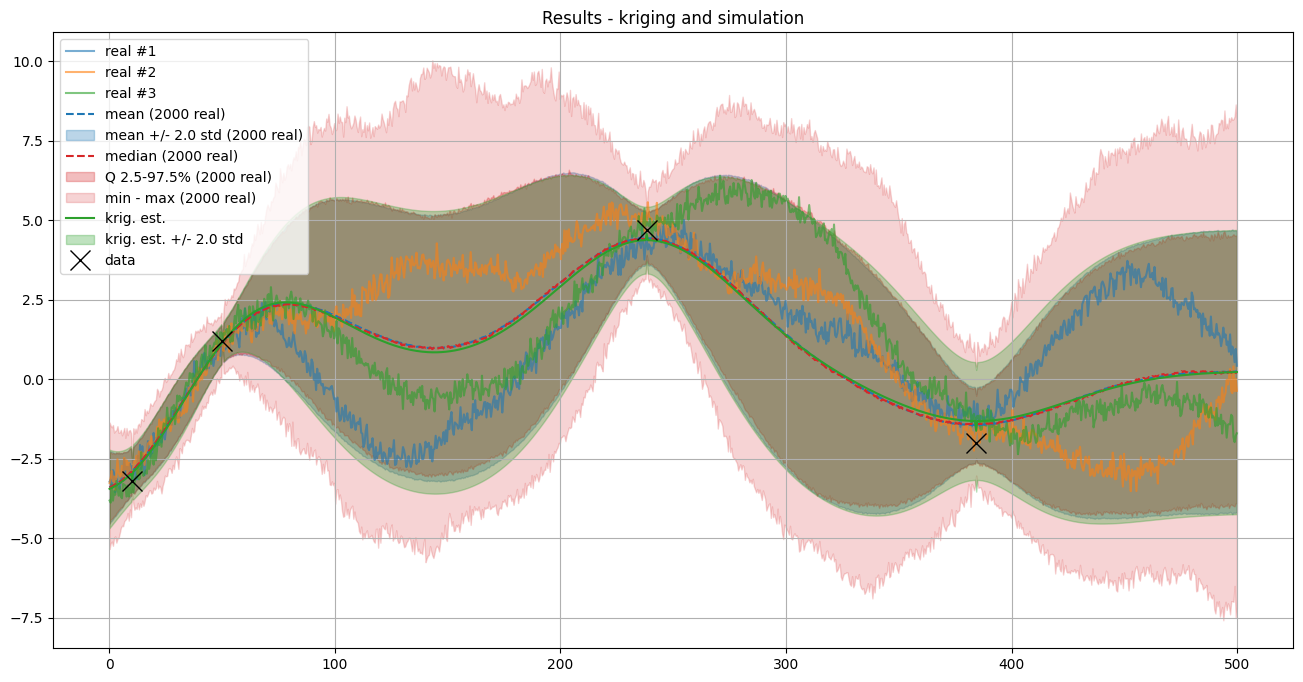

In [16]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- t std
col_sim_mean = 'tab:blue'
plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xc, 
                 simul_mean - t * simul_std, 
                 simul_mean + t * simul_std,
                 color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='solid', label=f'krig. est.')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation')

plt.show()

### Detailed results around data points

In [17]:
# Get data error std (array)
data_err_std = np.atleast_1d(v_err_std)
if data_err_std.size==1:
    data_err_std = np.ones_like(v)*data_err_std[0]

# Get index of conditioning location in the grid
data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the data points
x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]

print('Data location        :', x)
print('Data cell center loc.:', x_center)
print('Is close to cell center ? ', np.isclose(x, x_center))


Data location        : [10.1, 50.25, 238.5, 384.3]
Data cell center loc.: [np.float64(10.25), np.float64(50.25), np.float64(238.25), np.float64(384.25)]
Is close to cell center ?  [False  True False False]


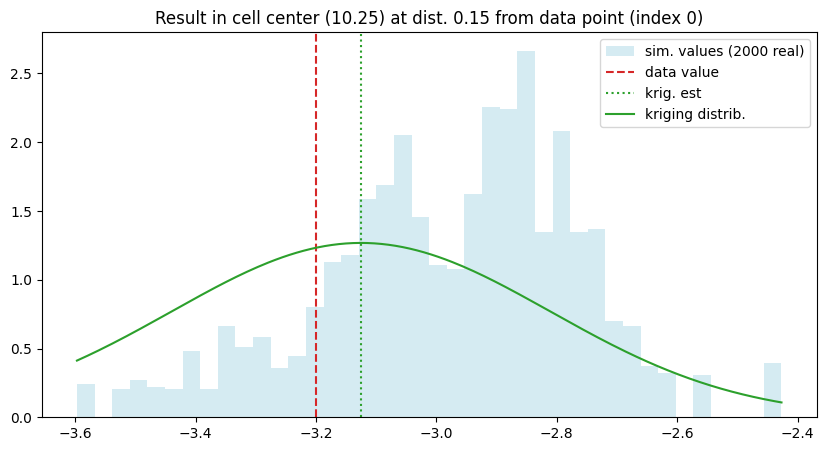

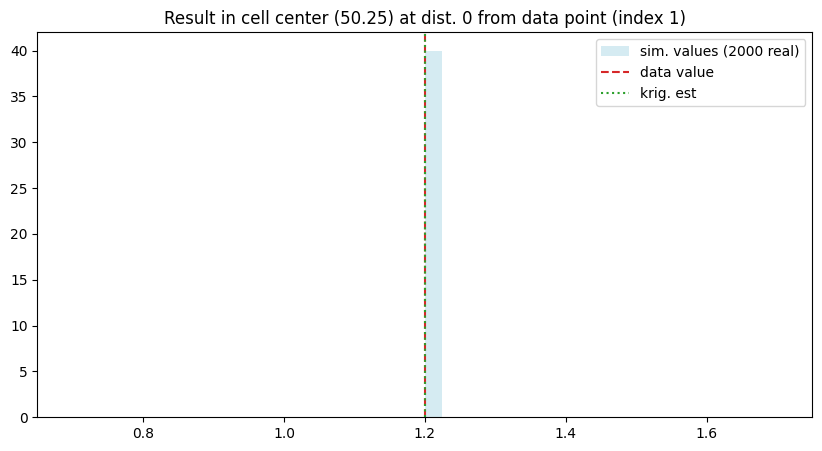

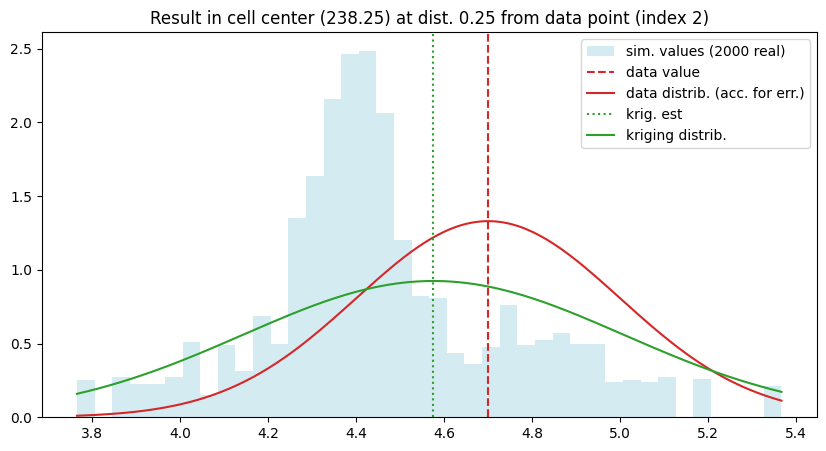

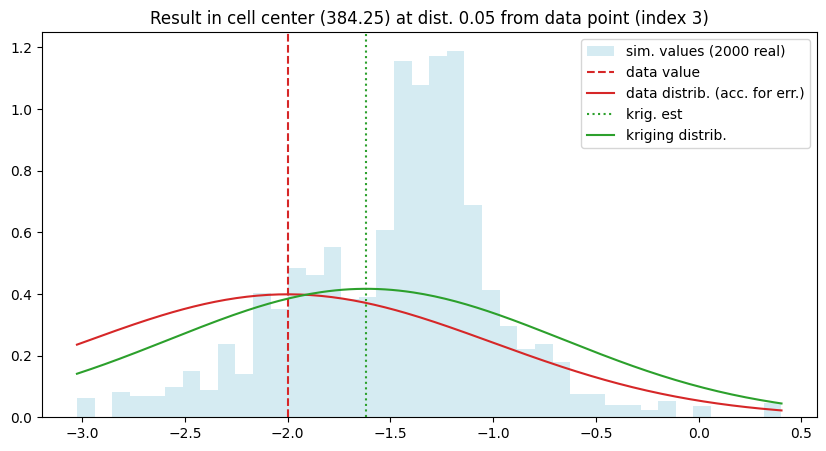

In [18]:
# Show results around data points
# -------------------------------
data_ind = range(len(x)) # choose index(es) of data point 

for j in data_ind:
    d = np.abs(x[j] - x_center[j])                      # distance from cell center to data location
    ix, iy, iz = data_grid_index[j]                     # grid index of cell containing the data point
    sim_v = simul_img.val[:, iz, iy, ix]                # simulated values at cell center
    krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix] # kriging estimate and std at cell center

    t = np.linspace(sim_v.min(), sim_v.max(), 200)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
    plt.axvline(v[j], c='tab:red', ls='dashed', label='data value')

    if data_err_std[j] > 0:
        plt.plot(t, scipy.stats.norm(loc=v[j], scale=data_err_std[j]).pdf(t), c='tab:red', ls='solid', label='data distrib. (acc. for err.)')

    plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
    if krig_v_std > 0:
        plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

    plt.legend()
    plt.title(f'Result in cell center ({x_center[j]}) at dist. {d:.3g} from data point (index {j})')
    plt.show()


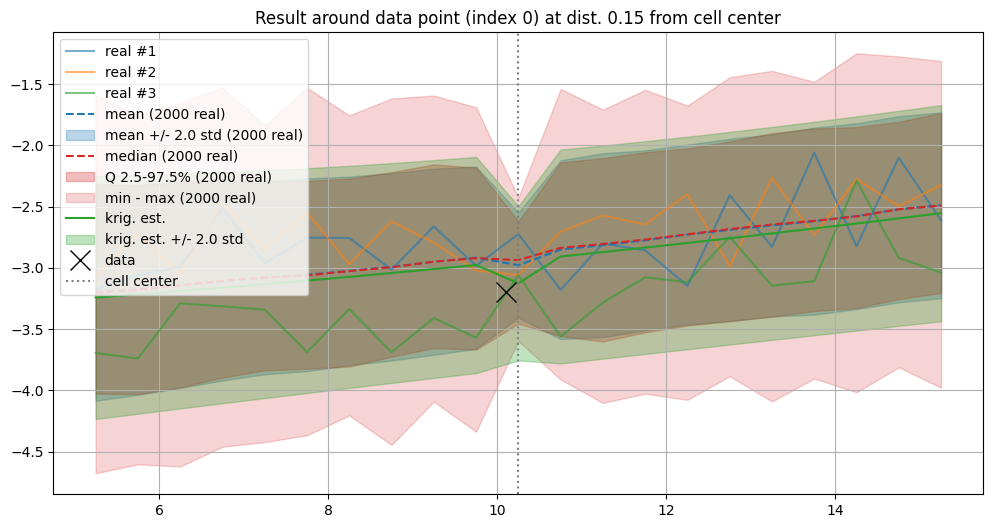

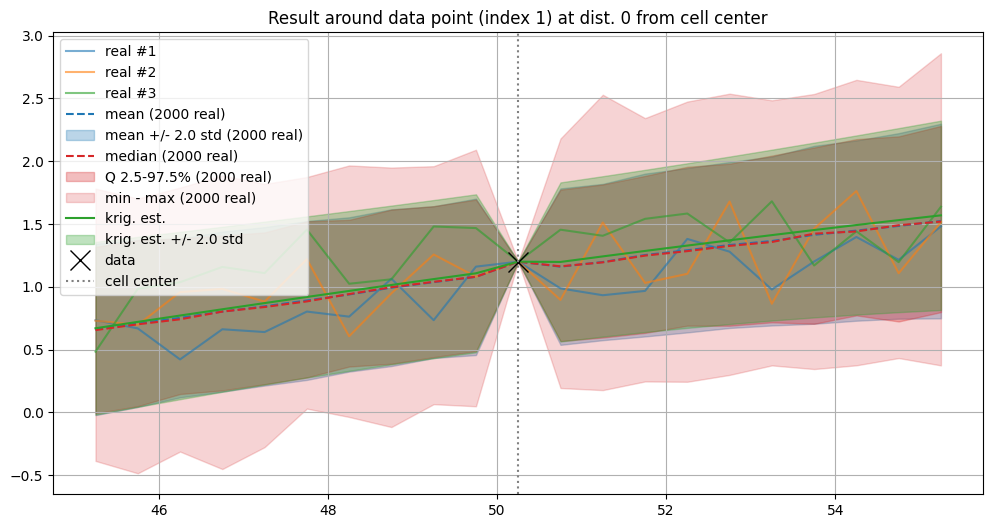

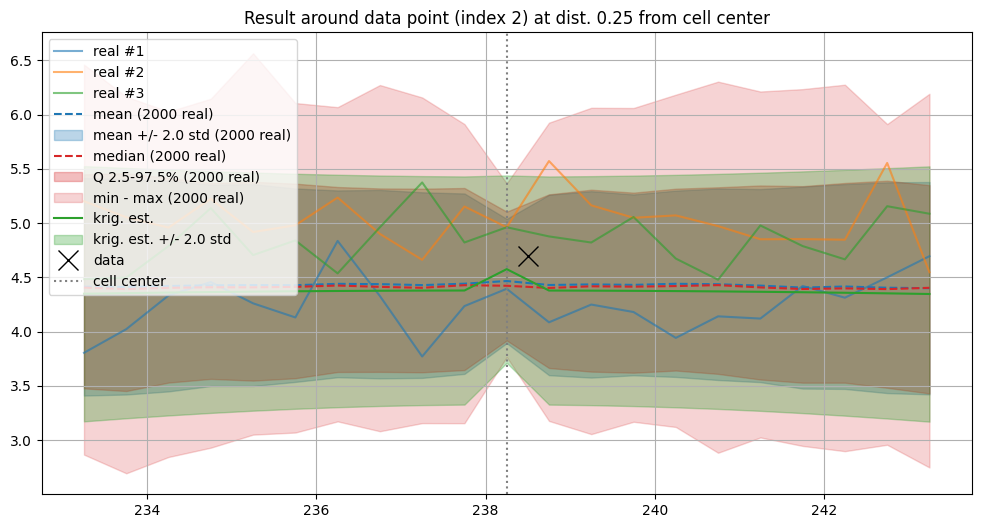

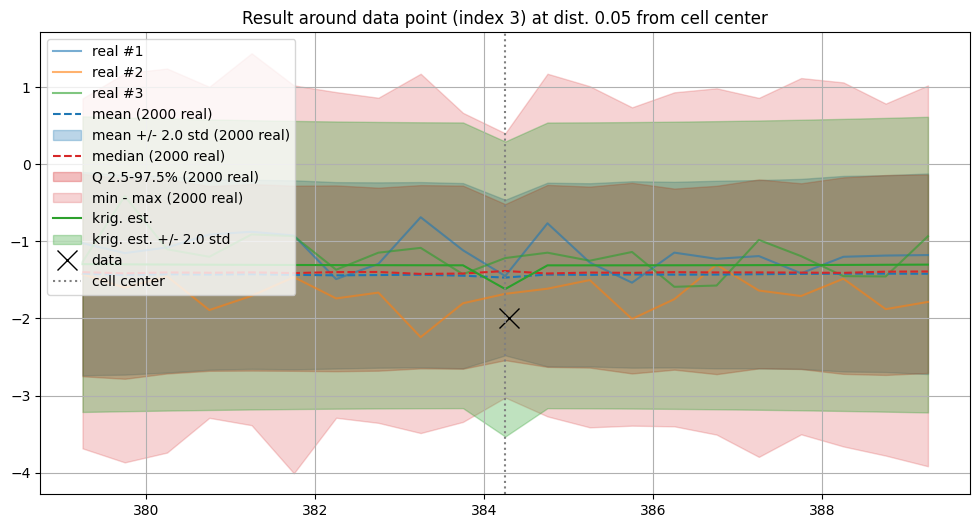

In [19]:
# Plot around data points
# -----------------------
data_ind = range(len(x)) # choose index(es) of data point 

t = 2.0 # get about 95% of the simulations

for j in data_ind:
    d = np.abs(x[j] - x_center[j])    # distance from cell center to data location
    ix, iy, iz = data_grid_index[j]   # grid index of cell containing the data point

    ind = np.arange(ix-10, ix+11) # index of grid cell to be plotted

    plt.figure(figsize=(12, 6))

    # First simulations
    for i in range(3):
        plt.plot(xc[ind], simul[i][ind], alpha=0.6, label=f'real #{i+1}')

    # Simulation mean and mean +/- t std
    col_sim_mean = 'tab:blue'
    plt.plot(xc[ind], simul_mean[ind], c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
    plt.fill_between(xc[ind], 
                    simul_mean[ind] - t * simul_std[ind],
                    simul_mean[ind] + t * simul_std[ind],
                    color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

    # Simulation median and quantiles and min-max
    col_sim_q = 'tab:red'
    plt.plot(xc[ind], simul_q[1][ind], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
    plt.fill_between(xc[ind], simul_q[0][ind], simul_q[2][ind],
                    color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
    plt.fill_between(xc[ind], simul_min[ind], simul_max[ind],
                    color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

    # Kriging
    col_krig = 'tab:green'
    plt.plot(xc[ind], krig_est[ind], c=col_krig, ls='solid', label=f'krig. est.')
    plt.fill_between(xc[ind], 
                    krig_est[ind] - t * krig_std[ind], 
                    krig_est[ind] + t * krig_std[ind],
                    color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

    plt.plot(x[j], v[j], 'x', c='k', markersize=15, label='data') # add data

    plt.axvline(xc[ix], c='gray', ls='dotted', label='cell center')

    plt.grid()
    plt.legend(loc='upper left')
    plt.title(f'Result around data point (index {j}) at dist. {d:.3g} from cell center')
    plt.show()

### Check results
For each data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean), and simulation.

*Note: the conditioning is "fully honoured" only for the data points located **exactly** in a cell center and a **zero data error**.*

In [20]:
# Check data
# ----------
# Get data error std (array)
data_err_std = np.atleast_1d(v_err_std)
if data_err_std.size==1:
    data_err_std = np.ones_like(v)*data_err_std[0]

# Get index of conditioning location in the grid
data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the data points
x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]
# Distance to center cell
dist_to_x_center = np.abs(np.asarray(x) - np.asarray(x_center))

# Check
for j in range(len(x)):
    print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
    ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
    krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
    sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
    print(f'   data value       = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
    print(f'   krig. mean value = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
    print(f'   simul.    : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.15
   data value       = -3.200e+00 [data error std = 0.000e+00]
   krig. mean value = -3.125e+00 [krig. std = 3.147e-01]
   simul.    : mean = -2.978e+00, min = -3.597e+00, max = -2.427e+00 [std = 2.143e-01]
Data point index 1, dist. to cell center = 0
   data value       = 1.200e+00 [data error std = 0.000e+00]
   krig. mean value = 1.200e+00 [krig. std = 0.000e+00]
   simul.    : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 4.441e-16]
Data point index 2, dist. to cell center = 0.25
   data value       = 4.700e+00 [data error std = 3.000e-01]
   krig. mean value = 4.575e+00 [krig. std = 4.317e-01]
   simul.    : mean = 4.466e+00, min = 3.766e+00, max = 5.366e+00 [std = 2.864e-01]
Data point index 3, dist. to cell center = 0.05
   data value       = -2.000e+00 [data error std = 1.000e+00]
   krig. mean value = -1.618e+00 [krig. std = 9.572e-01]
   simul.    : mean = -1.469e+00, min = -3.026e+00, max = 4.036e-01 [std = 5.049e-01

## 2. Example with data and inequality data

### Transforming inequality data to data with error

In [21]:
# Data
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                 #    float: same for all data points
                                 #    list or array: per data point

# Inequality data
x_ineq = [100.32, 185.75, 288.57] # locations (real coordinates)
v_ineq_min = [  np.nan,    1.2 ,  -2.9]  # lower bounds
v_ineq_max = [    -0.7, np.nan,   -1.4]  # upper bounds

# Type of kriging
method = 'simple_kriging'

### Estimation (kriging)

In [22]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                          # covariance model (required)
                            nx, sx, ox,                         # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std,      # data 
                            x_ineq=x_ineq,                      # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            method=method,                      # type of kriging
                            use_unique_neighborhood=True,       # search neighborhood ...
                            searchRadius=None,                  # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                          # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,                  # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                           # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.49 sec


In [23]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Simulation transforming inequality data to data with error

Here the approximation derived from the transformation of inequality data to data with error is applied, which is specified by the parameter `mode_transform_ineq_to_data=True`.

In [24]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = True # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
simulate: (Step 1.2) Transform inequality data to equality data with error std...
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (2000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed tim

### Plot the results

In [25]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


In [26]:
# Extract coordinates along x-axis (cell centers)
xc = krig_img.x() 
# xc = simul_img.x() # equiv.

# Extract kriging estimates and std
krig_est = krig_img.val[0, 0, 0, :]
krig_std = krig_img.val[1, 0, 0, :]

# Extract simulations
simul = simul_img.val[:, 0, 0, :] # all simulations, simul[i] : realization of index i
simul_mean = simul_img_mean.val[0, 0, 0, :] # or: simul_mean = np.mean(simul, axis=0)
simul_std  = simul_img_std.val [0, 0, 0, :] # or: simul_std = np.std(simul, axis=0)
simul_min  = simul_img_min.val [0, 0, 0, :] # or: simul_min = np.min(simul, axis=0)
simul_max  = simul_img_max.val [0, 0, 0, :] # or: simul_max = np.max(simul, axis=0)
simul_q    = simul_img_q.val   [:, 0, 0, :] # or: simul_q = np.quantile(simul, q=q, axis=0)


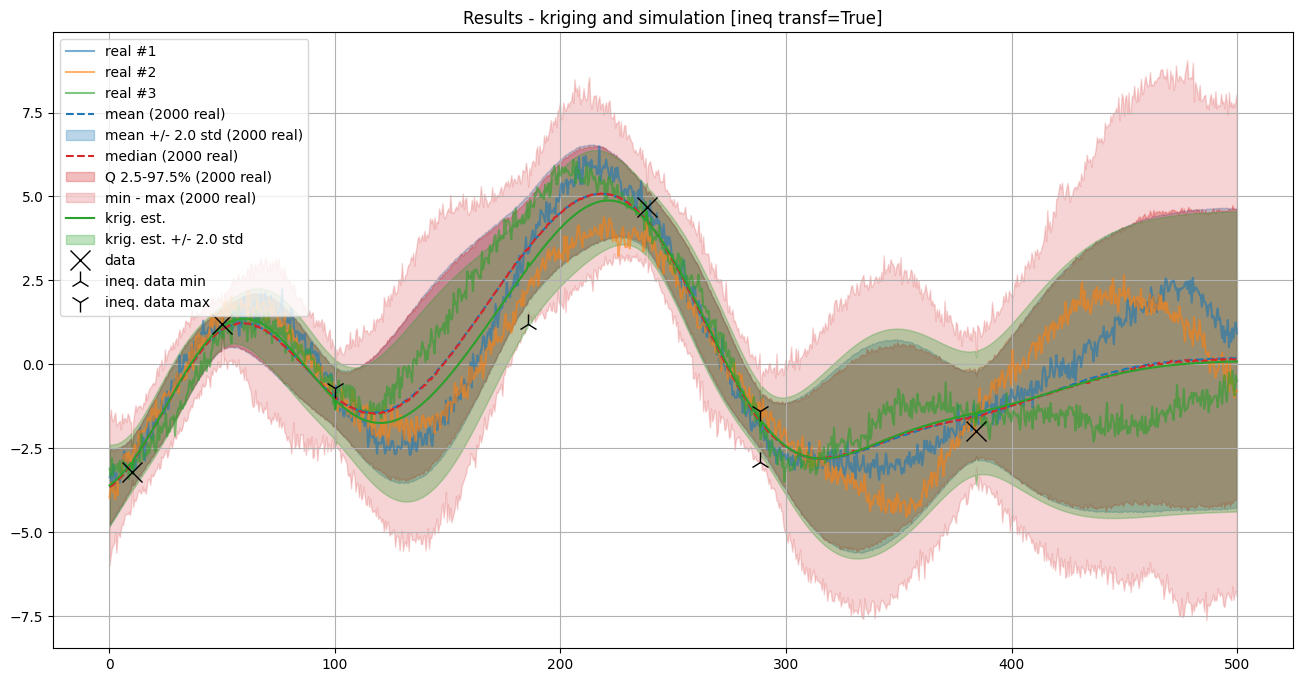

In [27]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- t std
col_sim_mean = 'tab:blue'
plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xc, 
                 simul_mean - t * simul_std, 
                 simul_mean + t * simul_std,
                 color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='solid', label=f'krig. est.')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data
if x_ineq is not None:
    plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')

plt.show()

### Detailed results around inequality data points

In [28]:
# Get index of conditioning location in the grid
ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]

print('Inequality data location        :', x_ineq)
print('Inequality data cell center loc.:', x_ineq_center)
print('Is close to cell center ? ', np.isclose(x_ineq, x_ineq_center))


Inequality data location        : [100.32, 185.75, 288.57]
Inequality data cell center loc.: [np.float64(100.25), np.float64(185.75), np.float64(288.75)]
Is close to cell center ?  [False  True False]


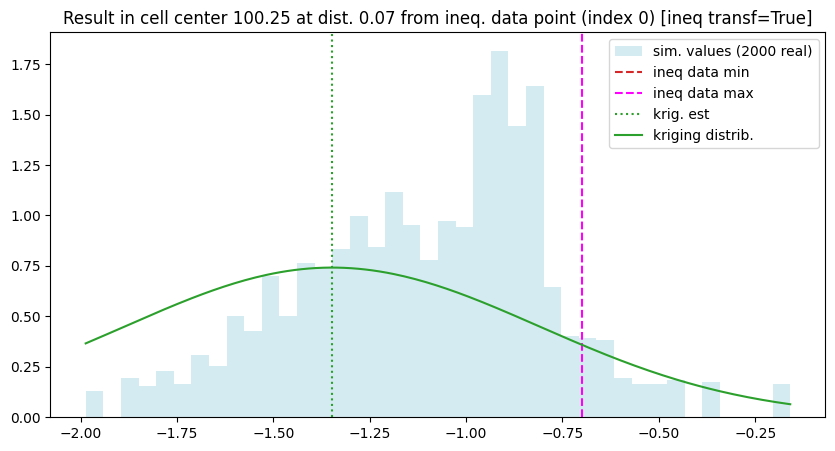

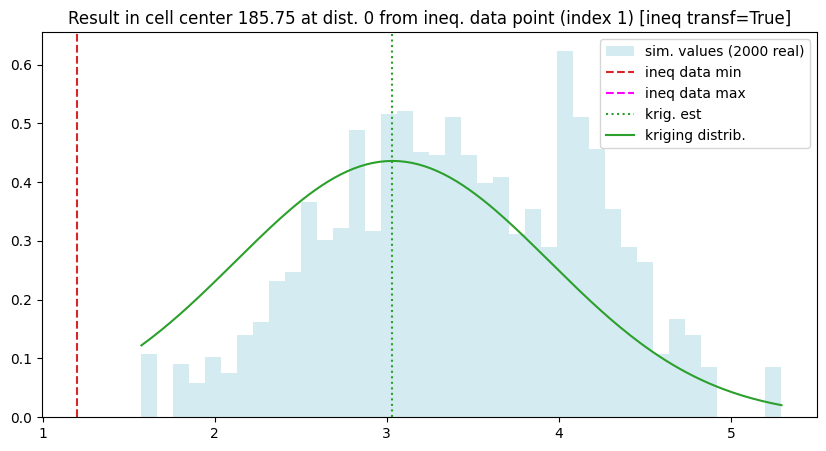

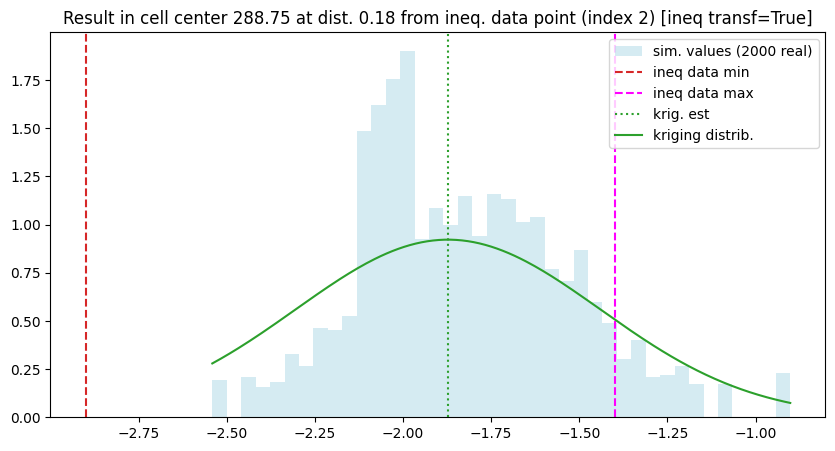

In [29]:
# Show results around an inequality data point
# --------------------------------------------
ineq_data_ind = range(len(x_ineq)) # choose index(es) of inequality data point 

for j in ineq_data_ind:
    d = np.abs(x_ineq[j] - x_ineq_center[j])            # distance from cell center to inequality data location
    ix, iy, iz = ineq_data_grid_index[j]                # grid index of cell containing the inequality data point
    sim_v = simul_img.val[:, iz, iy, ix]                # simulated values at cell center
    krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix] # kriging estimate and std at cell center

    t = np.linspace(sim_v.min(), sim_v.max(), 200)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
    plt.axvline(v_ineq_min[j], c='tab:red', ls='dashed', label='ineq data min') # not necessarily present (could be nan)
    plt.axvline(v_ineq_max[j], c='magenta', ls='dashed', label='ineq data max') # not necessarily present (could be nan)

    plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
    if krig_v_std > 0:
        plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

    plt.legend()
    plt.title(f'Result in cell center {x_ineq_center[j]} at dist. {d:.3g} from ineq. data point (index {j}) [ineq transf={mode_transform_ineq_to_data}]')
    plt.show()


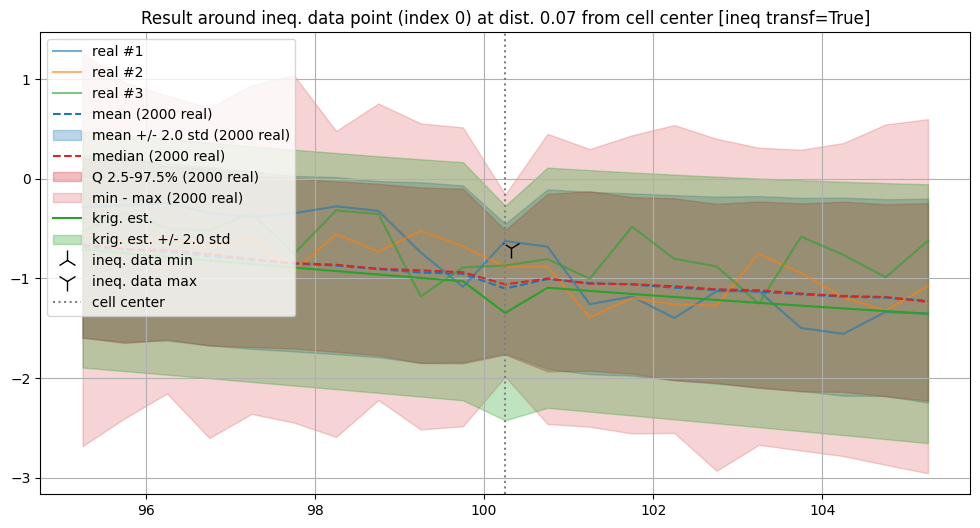

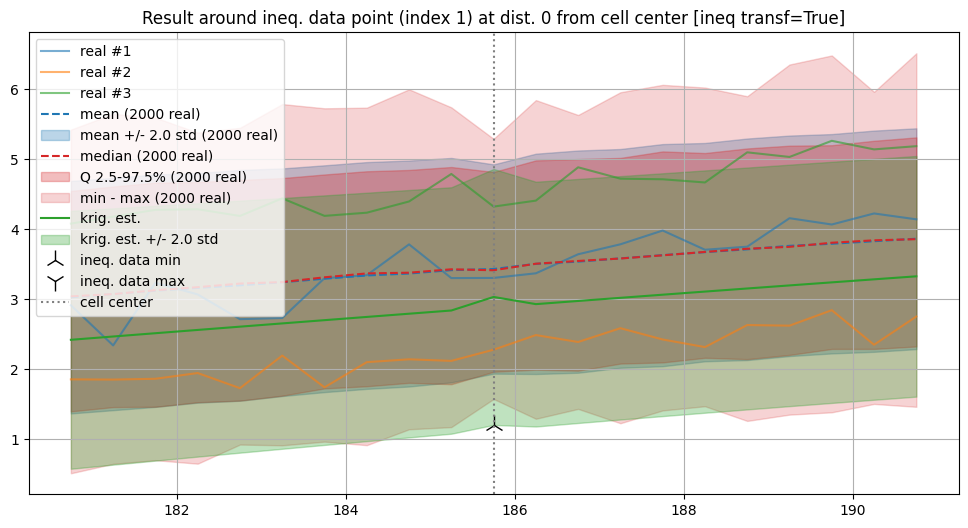

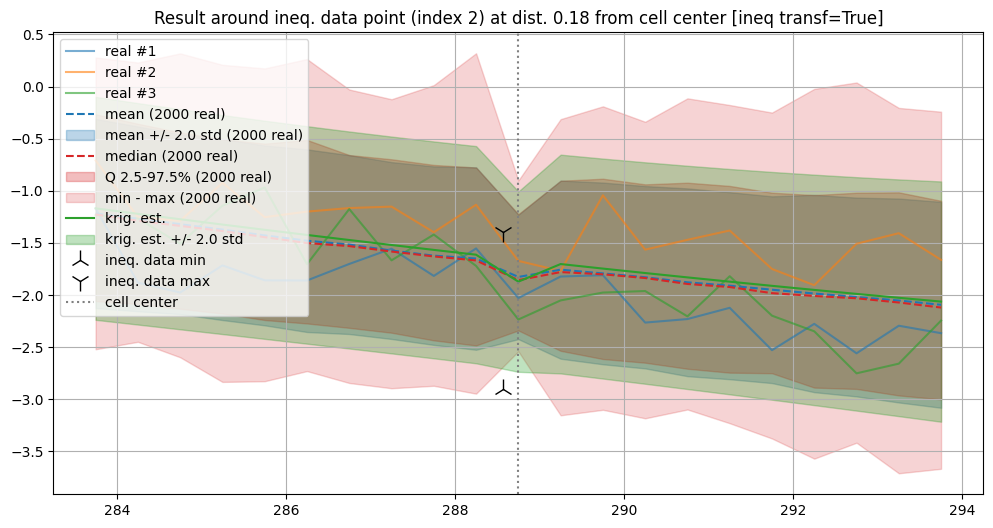

In [30]:
# Plot around inequality data points
# ----------------------------------
ineq_data_ind = range(len(x_ineq)) # choose index(es) of inequality data point 

t = 2.0 # get about 95% of the simulations

for j in ineq_data_ind:
    d = np.abs(x_ineq[j] - x_ineq_center[j])     # distance from cell center to ineq. data location
    ix, iy, iz = ineq_data_grid_index[j]         # grid index of cell containing the ineq. data point

    ind = np.arange(ix-10, ix+11) # index of grid cell to be plotted

    plt.figure(figsize=(12, 6))

    # First simulations
    for i in range(3):
        plt.plot(xc[ind], simul[i][ind], alpha=0.6, label=f'real #{i+1}')

    # Simulation mean and mean +/- t std
    col_sim_mean = 'tab:blue'
    plt.plot(xc[ind], simul_mean[ind], c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
    plt.fill_between(xc[ind], 
                    simul_mean[ind] - t * simul_std[ind],
                    simul_mean[ind] + t * simul_std[ind],
                    color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

    # Simulation median and quantiles and min-max
    col_sim_q = 'tab:red'
    plt.plot(xc[ind], simul_q[1][ind], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
    plt.fill_between(xc[ind], simul_q[0][ind], simul_q[2][ind],
                    color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
    plt.fill_between(xc[ind], simul_min[ind], simul_max[ind],
                    color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

    # Kriging
    col_krig = 'tab:green'
    plt.plot(xc[ind], krig_est[ind], c=col_krig, ls='solid', label=f'krig. est.')
    plt.fill_between(xc[ind], 
                    krig_est[ind] - t * krig_std[ind], 
                    krig_est[ind] + t * krig_std[ind],
                    color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

    plt.plot(x_ineq[j], v_ineq_min[j], '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq[j], v_ineq_max[j], '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

    plt.axvline(xc[ix], c='gray', ls='dotted', label='cell center')

    plt.grid()
    plt.legend(loc='upper left')
    plt.title(f'Result around ineq. data point (index {j}) at dist. {d:.3g} from cell center [ineq transf={mode_transform_ineq_to_data}]')

    plt.show()

### Simulation not transforming inequality data to data with error

Here the approximation derived from the transformation of inequality data to data with error is not applied (simulation only), which is specified by the parameter `mode_transform_ineq_to_data=False`.

In [31]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_dataB = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mode_transform_ineq_to_data=mode_transform_ineq_to_dataB,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulB_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (2000 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 999...
_ru

In [32]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Plot the results

In [33]:
# Compute mean and standard deviation (pixel-wise)
simulB_img_mean = gn.img.imageContStat(simulB_img, op='mean')
simulB_img_std  = gn.img.imageContStat(simulB_img, op='std')

# Compute min and max (pixel-wise)
simulB_img_min = gn.img.imageContStat(simulB_img, op='min')
simulB_img_max = gn.img.imageContStat(simulB_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simulB_img_q = gn.img.imageContStat(simulB_img, op='quantile', q=q)


In [34]:
# Extract simulations
simulB = simulB_img.val[:, 0, 0, :] # all simulations, simulB[i] : realization of index i
simulB_mean = simulB_img_mean.val[0, 0, 0, :] # or: simulB_mean = np.mean(simulB, axis=0)
simulB_std  = simulB_img_std.val [0, 0, 0, :] # or: simulB_std = np.std(simulB, axis=0)
simulB_min  = simulB_img_min.val [0, 0, 0, :] # or: simulB_min = np.min(simulB, axis=0)
simulB_max  = simulB_img_max.val [0, 0, 0, :] # or: simulB_max = np.max(simulB, axis=0)
simulB_q    = simulB_img_q.val   [:, 0, 0, :] # or: simulB_q = np.quantile(simulB, q=q, axis=0)


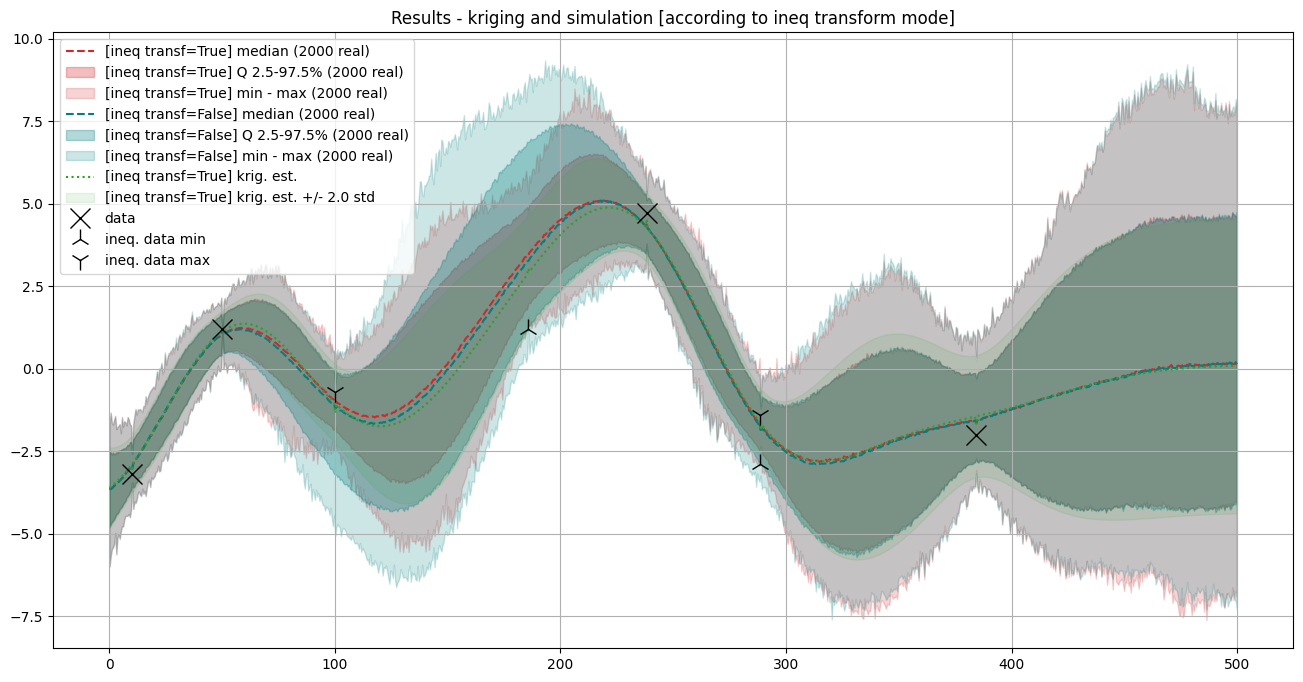

In [35]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# Simulation - mode : transforming ineq to data
# ---------------------------------------------
# # First simulations
# for i in range(3):
#     plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# # Simulation mean and mean +/- t std
# col_sim_mean = 'tab:blue'
# plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_data}] mean ({nreal} real)')
# plt.fill_between(xc, 
#                  simul_mean - t * simul_std, 
#                  simul_mean + t * simul_std,
#                  color=col_sim_mean, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_data}] mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_data}] median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_data}] Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'[ineq transf={mode_transform_ineq_to_data}] min - max ({nreal} real)')

# Simulation - mode : not transforming ineq to data
# -------------------------------------------------
# # First simulations
# for i in range(3):
#     plt.plot(xc, simulB[i], alpha=0.6, label=f'real (B) #{i+1}')

# # Simulation mean and mean +/- t std
# col_simB_mean = 'teal'
# plt.plot(xc, simulB_mean, c=col_simB_mean, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_dataB}] mean ({nreal} real)')
# plt.fill_between(xc, 
#                  simulB_mean - t * simulB_std, 
#                  simulB_mean + t * simulB_std,
#                  color=col_simB_mean, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_dataB}] mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_simB_q = 'teal'
plt.plot(xc, simulB_q[1], c=col_simB_q, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_dataB}] median ({nreal} real)')
plt.fill_between(xc, simulB_q[0], simulB_q[2],
                 color=col_simB_q, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_dataB}] Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simulB_min, simulB_max,
                 color=col_simB_q, alpha=.2, label=f'[ineq transf={mode_transform_ineq_to_dataB}] min - max ({nreal} real)')

# Kriging
# -------
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='dotted', label=f'[ineq transf=True] krig. est.')
# plt.plot(xc, krig_est - t * krig_std, c=col_krig, ls='dashed', label=f'[ineq transf=True] krig. est. +/- {t} std')
# plt.plot(xc, krig_est + t * krig_std, c=col_krig, ls='dashed')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.1, label=f'[ineq transf=True] krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data
if x_ineq is not None:
    plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation [according to ineq transform mode]')

plt.show()

**Remark:** the skewed distribution of simulated values is visible around inequality data location with only minimal value (lower bound) or maximal (upper bound) value. See below for more detail.

### Detailed results around inequality data points

In [36]:
# Get index of conditioning location in the grid
ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]

print('Inequality data location        :', x_ineq)
print('Inequality data cell center loc.:', x_ineq_center)
print('Is close to cell center ? ', np.isclose(x_ineq, x_ineq_center))


Inequality data location        : [100.32, 185.75, 288.57]
Inequality data cell center loc.: [np.float64(100.25), np.float64(185.75), np.float64(288.75)]
Is close to cell center ?  [False  True False]


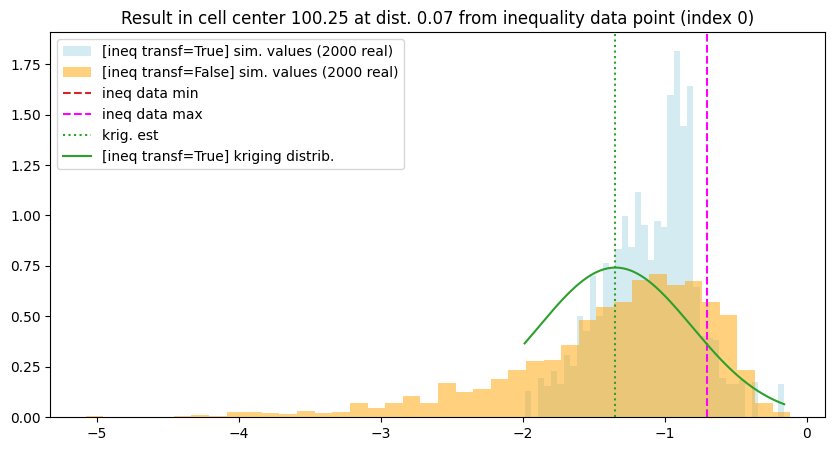

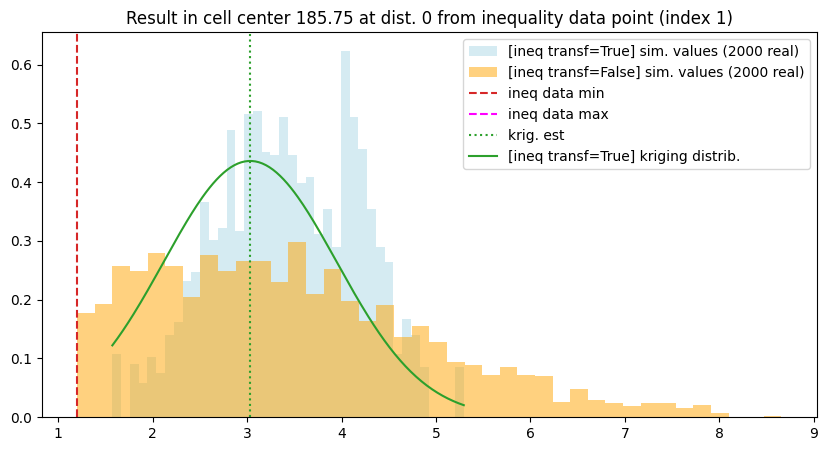

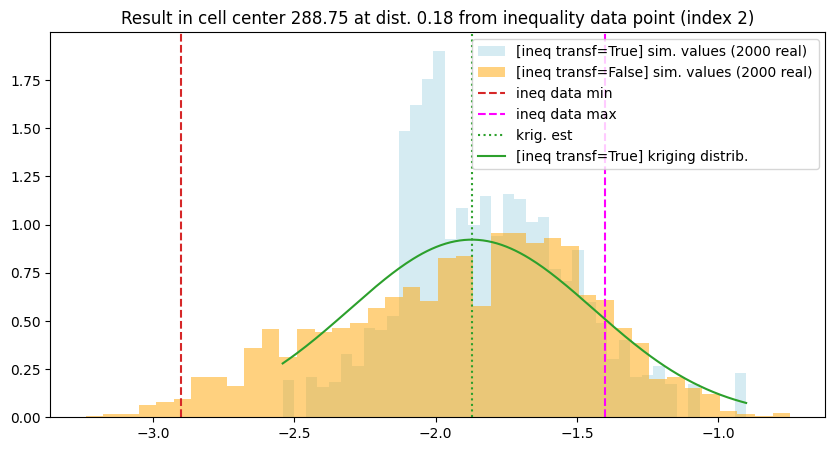

In [37]:
# Show results around an inequality data point
# --------------------------------------------
ineq_data_ind = range(len(x_ineq)) # choose index(es) of inequality data point 

for j in ineq_data_ind:
    d = np.abs(x_ineq[j] - x_ineq_center[j])            # distance from cell center to inequality data location
    ix, iy, iz = ineq_data_grid_index[j]                # grid index of cell containing the inequality data point
    sim_v = simul_img.val[:, iz, iy, ix]                # simulated values at cell center
    simB_v = simulB_img.val[:, iz, iy, ix]              # simulated values at cell center - alternative (not transforming ineq)
    krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix] # kriging estimate and std at cell center

    t = np.linspace(sim_v.min(), sim_v.max(), 200)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'[ineq transf={mode_transform_ineq_to_data}] sim. values ({nreal} real)')
    plt.hist(simB_v, bins=40, density=True, color='orange', alpha=0.5, label=f'[ineq transf={mode_transform_ineq_to_dataB}] sim. values ({nreal} real)')
    plt.axvline(v_ineq_min[j], c='tab:red', ls='dashed', label='ineq data min') # not necessarily present (could be nan)
    plt.axvline(v_ineq_max[j], c='magenta', ls='dashed', label='ineq data max') # not necessarily present (could be nan)

    plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
    if krig_v_std > 0:
        plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='[ineq transf=True] kriging distrib.')

    plt.legend()
    plt.title(f'Result in cell center {x_ineq_center[j]} at dist. {d:.3g} from inequality data point (index {j})')
    plt.show()


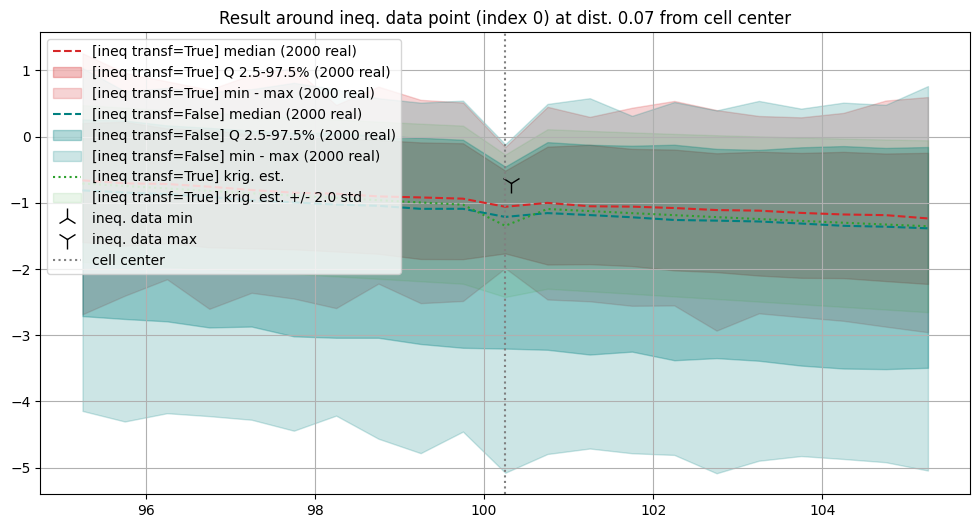

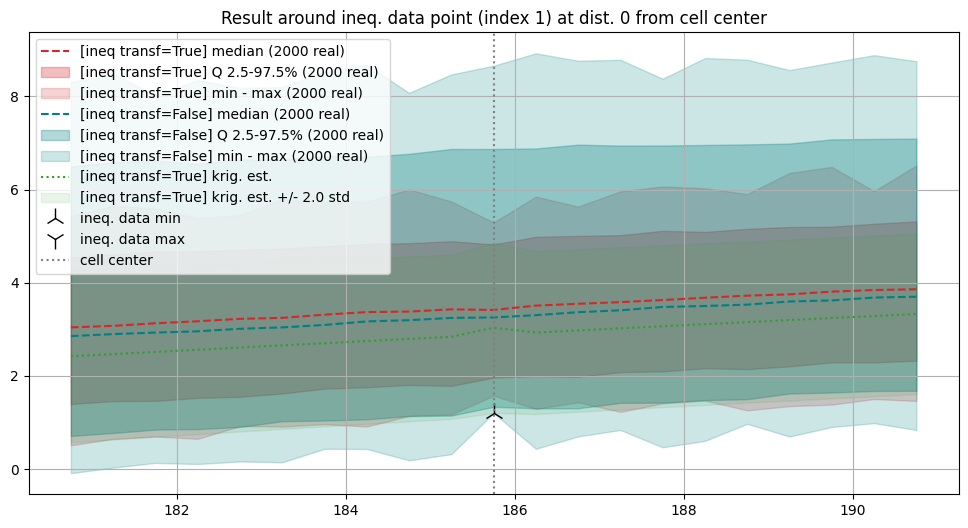

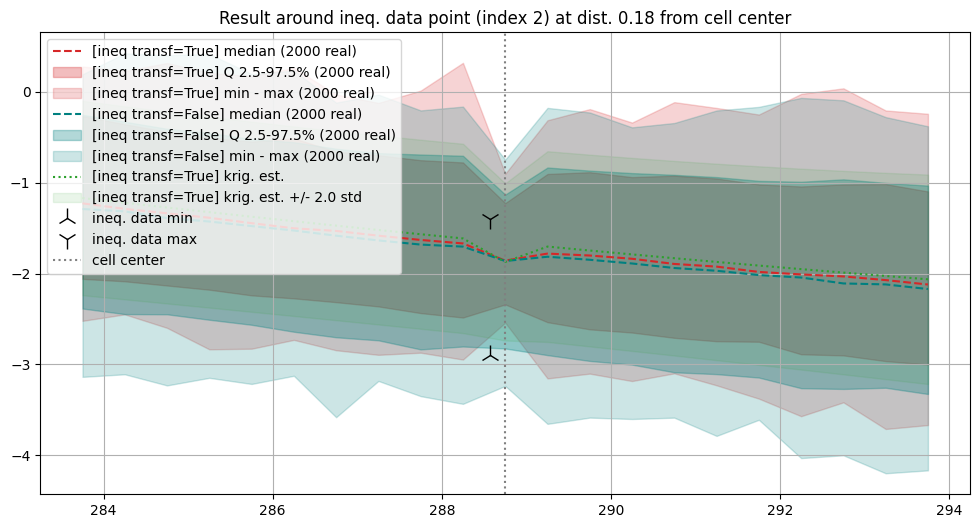

In [38]:
# Plot around inequality data points
# ----------------------------------
ineq_data_ind = range(len(x_ineq)) # choose index(es) of inequality data point 

t = 2.0 # get about 95% of the simulations

for j in ineq_data_ind:
    d = np.abs(x_ineq[j] - x_ineq_center[j])     # distance from cell center to ineq. data location
    ix, iy, iz = ineq_data_grid_index[j]         # grid index of cell containing the ineq. data point
    ind = np.arange(ix-10, ix+11) # index of grid cell to be plotted

    plt.figure(figsize=(12, 6))

    # Simulation - mode : transforming ineq to data
    # ---------------------------------------------
    # Simulation median and quantiles and min-max
    col_sim_q = 'tab:red'
    plt.plot(xc[ind], simul_q[1][ind], c=col_sim_q, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_data}] median ({nreal} real)')
    plt.fill_between(xc[ind], simul_q[0][ind], simul_q[2][ind],
                    color=col_sim_q, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_data}] Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
    plt.fill_between(xc[ind], simul_min[ind], simul_max[ind],
                    color=col_sim_q, alpha=.2, label=f'[ineq transf={mode_transform_ineq_to_data}] min - max ({nreal} real)')

    # Simulation - mode : not transforming ineq to data
    # -------------------------------------------------
    # Simulation median and quantiles and min-max
    col_simB_q = 'teal'
    plt.plot(xc[ind], simulB_q[1][ind], c=col_simB_q, ls='dashed', label=f'[ineq transf={mode_transform_ineq_to_dataB}] median ({nreal} real)')
    plt.fill_between(xc[ind], simulB_q[0][ind], simulB_q[2][ind],
                    color=col_simB_q, alpha=.3, label=f'[ineq transf={mode_transform_ineq_to_dataB}] Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
    plt.fill_between(xc[ind], simulB_min[ind], simulB_max[ind],
                    color=col_simB_q, alpha=.2, label=f'[ineq transf={mode_transform_ineq_to_dataB}] min - max ({nreal} real)')

    # # Kriging
    # # -------
    col_krig = 'tab:green'
    plt.plot(xc[ind], krig_est[ind], c=col_krig, ls='dotted', label=f'[ineq transf=True] krig. est.')
    # plt.plot(xc[ind], krig_est[ind] - t * krig_std[ind], c=col_krig, ls='dashed', label=f'[ineq transf=True] krig. est. +/- {t} std')
    # plt.plot(xc[ind], krig_est[ind] + t * krig_std[ind], c=col_krig, ls='dashed')
    plt.fill_between(xc[ind], 
                    krig_est[ind] - t * krig_std[ind], 
                    krig_est[ind] + t * krig_std[ind],
                    color=col_krig, alpha=.1, label=f'[ineq transf=True] krig. est. +/- {t} std')

    plt.plot(x_ineq[j], v_ineq_min[j], '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq[j], v_ineq_max[j], '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

    plt.axvline(xc[ix], c='gray', ls='dotted', label='cell center')

    plt.grid()
    plt.legend(loc='upper left')
    plt.title(f'Result around ineq. data point (index {j}) at dist. {d:.3g} from cell center')

    plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [39]:
# Check data
# ----------
# Get data error std (array)
data_err_std = np.atleast_1d(v_err_std)
if data_err_std.size==1:
    data_err_std = np.ones_like(v)*data_err_std[0]

# Get index of conditioning location in the grid
data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the data points
x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]
# Distance to center cell
dist_to_x_center = np.abs(np.asarray(x) - np.asarray(x_center))

# Check
for j in range(len(x)):
    print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
    ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
    krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
    sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
    simB_v = simulB_img.val[:, iz, iy, ix]               # simulated values at cell center - alternative (not transforming ineq)
    print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
    print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
    print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')
    print(f'   simul. [ineq transf={str(mode_transform_ineq_to_dataB):<5}]   : mean = {simB_v.mean():.3e}, min = {simB_v.min():.3e}, max = {simB_v.max():.3e} [std = {simB_v.std():.3e}]')


Data point index 0, dist. to cell center = 0.15
   data value                         = -3.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.108e+00 [krig. std = 3.145e-01]
   simul. [ineq transf=True ]   : mean = -3.028e+00, min = -3.568e+00, max = -2.399e+00 [std = 2.045e-01]
   simul. [ineq transf=False]   : mean = -3.026e+00, min = -3.572e+00, max = -2.382e+00 [std = 2.047e-01]
Data point index 1, dist. to cell center = 0
   data value                         = 1.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.200e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=True ]   : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 4.441e-16]
   simul. [ineq transf=False]   : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 4.440e-16]
Data point index 2, dist. to cell center = 0.25
   data value                         = 4.700e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.539e+00 [

In [40]:
# Check inequality data
# ---------------------
# Get index of conditioning location in the grid
ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]
# Distance to center cell
dist_to_x_ineq_center = np.abs(np.asarray(x_ineq) - np.asarray(x_ineq_center))

# Check
for j in range(len(x_ineq)):
    print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
    ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
    krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
    sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
    simB_v = simulB_img.val[:, iz, iy, ix]   # simulated values at cell center - alternative (not transforming ineq)
    if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
        print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
        print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_dataB):<5}]: {100*np.mean(simB_v >= v_ineq_min[j]):.3f}%')
    if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
        print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
        print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')
        print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_dataB):<5}]: {100*np.mean(simB_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.07
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=True ]: 91.650%
   percentage of simul. respecting ineq data max [ineq transf=False]: 84.550%
Ineq. data point index 1, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=True ]: 100.000%
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
Ineq. data point index 2, dist. to cell center = 0.18
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=True ]: 100.000%
   percentage of simul. respecting ineq data min [ineq transf=False]: 98.550%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=True ]: 

## 3. Example with imposed mean and/or variance (simple kriging only)
Mean and variance in the simulation grid can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).


### 3.1 Constant mean and variance
Set mean to $5.0$ and variance to the double of the covariance model sill. No inequality is considered in this example.

In [41]:
# Data
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                 #    float: same for all data points
                                 #    list or array: per data point

# Inequality data
x_ineq = [100.32, 185.75, 288.57] # locations (real coordinates)
v_ineq_min = [  np.nan,    1.2 ,  -2.9]  # lower bounds
v_ineq_max = [    -0.7, np.nan,   -1.4]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Specify mean and variance
mean = 5.0
var = 2.0 * cov_model.sill()

### Estimation (kriging)

In [42]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                          # covariance model (required)
                            nx, sx, ox,                         # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std,      # data 
                            x_ineq=x_ineq,                      # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mean=mean,                          # mean
                            var=var,                            # variance
                            method='simple_kriging',            # type of kriging
                            use_unique_neighborhood=True,       # search neighborhood ...
                            searchRadius=None,                  # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                          # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,                  # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                           # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.51 sec


In [43]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Simulations

In [44]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean,                     # mean
                            var=var,                       # variance
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (2000 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 999...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 999...
_ru

In [45]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Plot the results

In [46]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


In [47]:
# Extract coordinates along x-axis (cell centers)
xc = krig_img.x() 
# xc = simul_img.x() # equiv.

# Extract kriging estimates and std
krig_est = krig_img.val[0, 0, 0, :]
krig_std = krig_img.val[1, 0, 0, :]

# Extract simulations
simul = simul_img.val[:, 0, 0, :] # all simulations, simul[i] : realization of index i
simul_mean = simul_img_mean.val[0, 0, 0, :] # or: simul_mean = np.mean(simul, axis=0)
simul_std  = simul_img_std.val [0, 0, 0, :] # or: simul_std = np.std(simul, axis=0)
simul_min  = simul_img_min.val [0, 0, 0, :] # or: simul_min = np.min(simul, axis=0)
simul_max  = simul_img_max.val [0, 0, 0, :] # or: simul_max = np.max(simul, axis=0)
simul_q    = simul_img_q.val   [:, 0, 0, :] # or: simul_q = np.quantile(simul, q=q, axis=0)


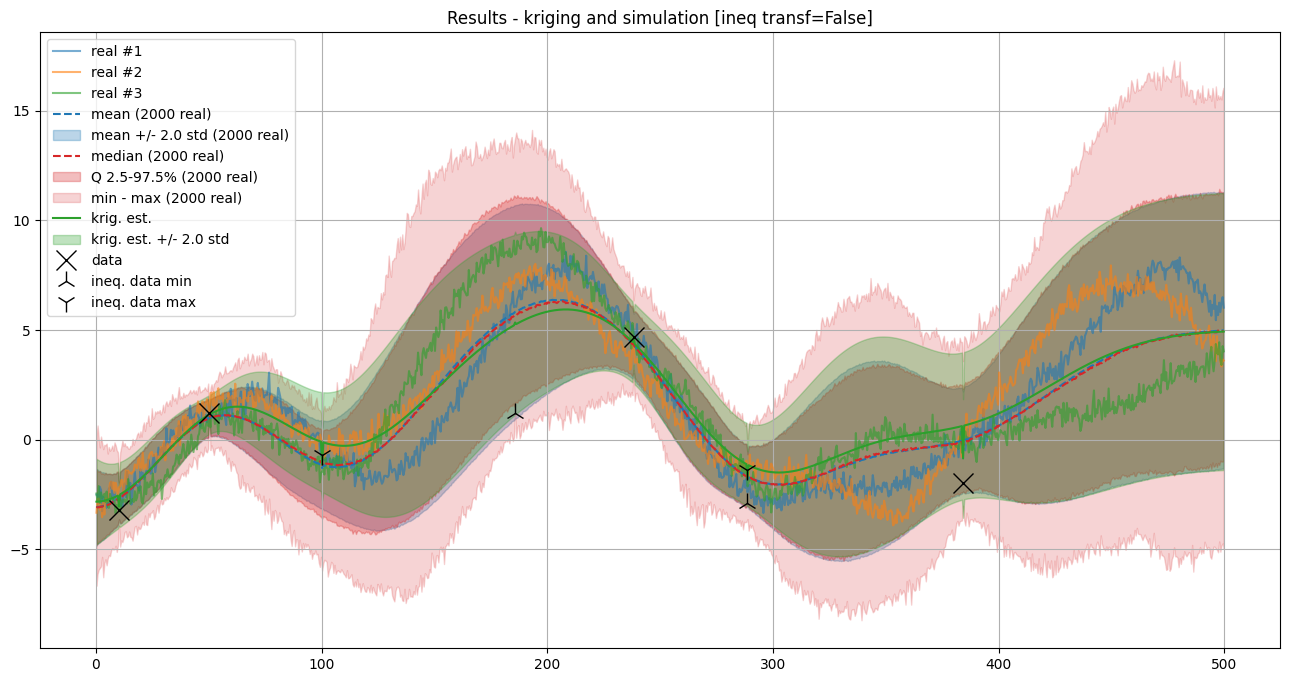

In [48]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- t std
col_sim_mean = 'tab:blue'
plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xc, 
                 simul_mean - t * simul_std, 
                 simul_mean + t * simul_std,
                 color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='solid', label=f'krig. est.')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data
if x_ineq is not None:
    plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')

plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [49]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]
    # Distance to center cell
    dist_to_x_center = np.abs(np.asarray(x) - np.asarray(x_center))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.15
   data value                         = -3.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.067e+00 [krig. std = 4.448e-01]
   simul. [ineq transf=False]   : mean = -2.823e+00, min = -3.901e+00, max = -1.543e+00 [std = 4.059e-01]
Data point index 1, dist. to cell center = 0
   data value                         = 1.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.200e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 6.661e-16]
Data point index 2, dist. to cell center = 0.25
   data value                         = 4.700e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.634e+00 [krig. std = 6.082e-01]
   simul. [ineq transf=False]   : mean = 4.386e+00, min = 2.861e+00, max = 6.353e+00 [std = 6.770e-01]
Data point index 3, dist. to cell center = 0.05
   data value                      

In [50]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]
    # Distance to center cell
    dist_to_x_ineq_center = np.abs(np.asarray(x_ineq) - np.asarray(x_ineq_center))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.07
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 72.850%
Ineq. data point index 1, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
Ineq. data point index 2, dist. to cell center = 0.18
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 96.700%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 76.350%


### 3.2 Non-stationary mean and variance
Set the mean varying linearly from $-10.0$ (at the left border) to $+10.0$ (at the right border), and the variance
from $0.1$ to $4.0$.

In [51]:
# Data
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                 #    float: same for all data points
                                 #    list or array: per data point

# Inequality data
# x_ineq = [100.32, 185.75, 288.57] # locations (real coordinates)
# v_ineq_min = [  np.nan,    1.2 ,  -2.9]  # lower bounds
# v_ineq_max = [    -0.7, np.nan,   -1.4]  # upper bounds
x_ineq = None
v_ineq_min = None
v_ineq_max = None

# Specify mean and variance
mean = np.linspace(-10, 10, nx)
var = np.linspace(0.1, 4, nx)

# Note:
# ----
# In function `gn.geosclassicinterface.estimate` and `gn.geosclassicinterface.simulate`, 
# the parameters `mean` and `var` can also be functions that take one parameter (location in 1D grid) and
# return one value


### Estimation (kriging)

In [52]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                          # covariance model (required)
                            nx, sx, ox,                         # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std,      # data 
                            x_ineq=x_ineq,                      # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mean=mean,                          # mean
                            var=var,                            # variance
                            method='simple_kriging',            # type of kriging
                            use_unique_neighborhood=False,       # search neighborhood ...
                            searchRadius=None,                  # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                          # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,                  # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                           # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.0064 sec


In [53]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Simulations

In [54]:
# Number of realizations
nreal = 2000

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean,                     # mean
                            var=var,                       # variance
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (2000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 3.1 sec


In [55]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Plot the results

In [56]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


In [57]:
# Extract coordinates along x-axis (cell centers)
xc = krig_img.x() 
# xc = simul_img.x() # equiv.

# Extract kriging estimates and std
krig_est = krig_img.val[0, 0, 0, :]
krig_std = krig_img.val[1, 0, 0, :]

# Extract simulations
simul = simul_img.val[:, 0, 0, :] # all simulations, simul[i] : realization of index i
simul_mean = simul_img_mean.val[0, 0, 0, :] # or: simul_mean = np.mean(simul, axis=0)
simul_std  = simul_img_std.val [0, 0, 0, :] # or: simul_std = np.std(simul, axis=0)
simul_min  = simul_img_min.val [0, 0, 0, :] # or: simul_min = np.min(simul, axis=0)
simul_max  = simul_img_max.val [0, 0, 0, :] # or: simul_max = np.max(simul, axis=0)
simul_q    = simul_img_q.val   [:, 0, 0, :] # or: simul_q = np.quantile(simul, q=q, axis=0)


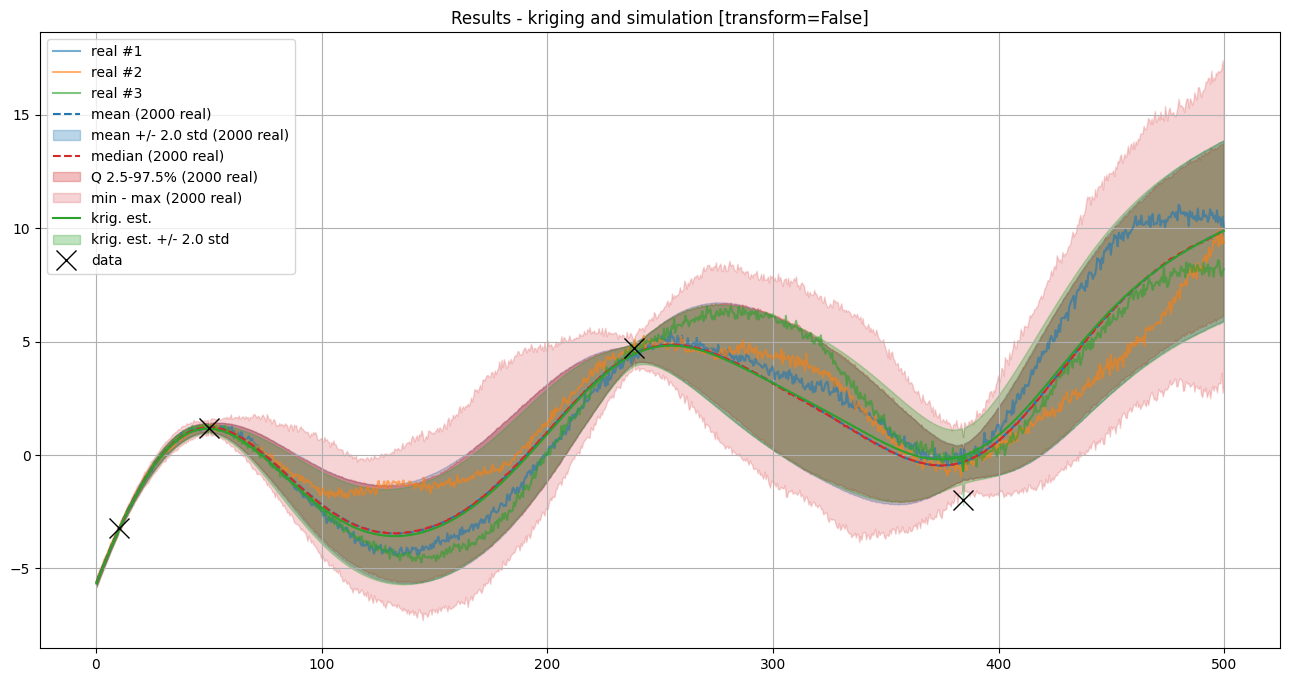

In [58]:
# Plot the first realizations, the mean and the mean +/- t * standard deviation
t = 2.0 # get about 95% of the simulations

plt.figure(figsize=(16,8))

# First simulations
for i in range(3):
    plt.plot(xc, simul[i], alpha=0.6, label=f'real #{i+1}')

# Simulation mean and mean +/- t std
col_sim_mean = 'tab:blue'
plt.plot(xc, simul_mean, c=col_sim_mean, ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xc, 
                 simul_mean - t * simul_std, 
                 simul_mean + t * simul_std,
                 color=col_sim_mean, alpha=.3, label=f'mean +/- {t} std ({nreal} real)')

# Simulation median and quantiles and min-max
col_sim_q = 'tab:red'
plt.plot(xc, simul_q[1], c=col_sim_q, ls='dashed', label=f'median ({nreal} real)')
plt.fill_between(xc, simul_q[0], simul_q[2],
                 color=col_sim_q, alpha=.3, label=f'Q {100*q[0]:3.1f}-{100*q[2]:3.1f}% ({nreal} real)')
plt.fill_between(xc, simul_min, simul_max,
                 color=col_sim_q, alpha=.2, label=f'min - max ({nreal} real)')

# Kriging
col_krig = 'tab:green'
plt.plot(xc, krig_est, c=col_krig, ls='solid', label=f'krig. est.')
plt.fill_between(xc, 
                 krig_est - t * krig_std, 
                 krig_est + t * krig_std,
                 color=col_krig, alpha=.3, label=f'krig. est. +/- {t} std')

if x is not None:
    plt.plot(x, v, 'x', c='k', markersize=15, label='data') # add data
if x_ineq is not None:
    plt.plot(x_ineq, v_ineq_min, '2', c='k', markersize=15, label='ineq. data min') # add inequality data, lower bound
    plt.plot(x_ineq, v_ineq_max, '1', c='k', markersize=15, label='ineq. data max') # add inequality data, lower bound

# # Underlying mean and variance
# plt.plot(xc, mean, c='gray', ls='dashed', label='underlying mean')
# plt.plot(xc, mean-t*np.sqrt(var), c='gray', ls='dotted', label='underlying mean +/- {t} std')
# plt.plot(xc, mean+t*np.sqrt(var), c='gray', ls='dotted')

plt.grid()
plt.legend()
plt.title(f'Results - kriging and simulation [transform={mode_transform_ineq_to_data}]')

plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [59]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in data_grid_index]
    # Distance to center cell
    dist_to_x_center = np.abs(np.asarray(x) - np.asarray(x_center))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.15
   data value                         = -3.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.216e+00 [krig. std = 5.938e-02]
   simul. [ineq transf=False]   : mean = -3.214e+00, min = -3.237e+00, max = -3.195e+00 [std = 7.692e-03]
Data point index 1, dist. to cell center = 0
   data value                         = 1.200e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.200e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = 1.200e+00, min = 1.200e+00, max = 1.200e+00 [std = 6.661e-16]
Data point index 2, dist. to cell center = 0.25
   data value                         = 4.700e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.545e+00 [krig. std = 2.701e-01]
   simul. [ineq transf=False]   : mean = 4.497e+00, min = 4.221e+00, max = 4.852e+00 [std = 1.128e-01]
Data point index 3, dist. to cell center = 0.05
   data value                      

In [60]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = [simul_img.xx()[iz, iy, ix] for ix, iy, iz in ineq_data_grid_index]
    # Distance to center cell
    dist_to_x_ineq_center = np.abs(np.asarray(x_ineq) - np.asarray(x_ineq_center))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')
